## Linear Quantization: Symmetric Mode
- Implement a function which returns the `scale` for Linear Quantization in Symmetric Mode.

There are two modes in Linear Quantization:
- Asymmetric: We map [r_min,r_max} to [q_nim,q_max].

- Symmetric: We map [-r_max,r_max] to [-r_max,q_max]
where we can set r_max=max(|r_tensor|)

  - Where we dont need to use the zero
  point (z=0).
  - This happens because the floating point range and the quantized range are symmetric with respect to zero.

  Hence, we can simplify the equation:
  - q=int(round(r/s))
  - s=r_max/q_max
  

In [1]:
import torch

In [2]:
def get_q_scale_symmetric(tensor, dtype=torch.int8):
    r_max = tensor.abs().max().item()
    q_max = torch.iinfo(dtype).max

    # return the scale
    return r_max/q_max

In [3]:
### test the implementation on a 4x4 matrix
test_tensor = torch.randn((4, 4))

In [4]:
test_tensor

tensor([[ 1.0460,  0.4989, -0.1189,  0.2233],
        [ 0.2531,  0.7470, -0.0039, -0.7797],
        [-1.4578, -0.4096,  0.6451, -1.5903],
        [ 1.3645, -0.1721, -0.3272,  0.6899]])

In [5]:
get_q_scale_symmetric(test_tensor)

0.012521923996332123

In [13]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import torch


def quantization_error(tensor, dequantized_tensor):
    return (dequantized_tensor - tensor).abs().square().mean()


def linear_q_with_scale_and_zero_point(
    r_tensor, scale, zero_point, dtype=torch.int8):
    """
    Performs simple linear quantization given
    the scale and zero-point.
    """

    # scale tensor and add the zero point
    scaled_and_shifted_tensor = r_tensor / scale + zero_point

    # round the tensor
    rounded_tensor = torch.round(scaled_and_shifted_tensor)

    # we need to clamp to the min/max value of the specified dtype
    q_min, q_max = torch.iinfo(dtype).min, torch.iinfo(dtype).max
    q_tensor = rounded_tensor.clamp(q_min, q_max).to(dtype)
    return q_tensor


def linear_dequantization(quantized_tensor, scale, zero_point):
    """
    Linear de-quantization
    """
    dequantized_tensor = scale * (quantized_tensor.float() - zero_point)

    return dequantized_tensor

def plot_matrix(tensor, ax, title, vmin=0, vmax=1, cmap=None):
    """
    Plot a heatmap of tensors using seaborn
    """
    sns.heatmap(tensor.cpu().numpy(), ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, annot=True, fmt=".2f", cbar=False)
    ax.set_title(title)
    ax.set_yticklabels([])
    ax.set_xticklabels([])


def plot_quantization_errors(original_tensor, quantized_tensor, dequantized_tensor, dtype = torch.int8, n_bits = 8):
    """
    A method that plots 4 matrices, the original tensor, the quantized tensor
    the de-quantized tensor and the error tensor.
    """
    # Get a figure of 4 plots
    fig, axes = plt.subplots(1, 4, figsize=(15, 4))

    # Plot the first matrix
    plot_matrix(original_tensor, axes[0], 'Original Tensor', cmap=ListedColormap(['white']))

    # Get the quantization range and plot the quantized tensor
    q_min, q_max = torch.iinfo(dtype).min, torch.iinfo(dtype).max
    plot_matrix(quantized_tensor, axes[1], f'{n_bits}-bit Linear Quantized Tensor', vmin=q_min, vmax=q_max, cmap='coolwarm')

    # Plot the de-quantized tensors
    plot_matrix(dequantized_tensor, axes[2], 'Dequantized Tensor', cmap='coolwarm')

    # Get the quantization errors
    q_error_tensor = abs(original_tensor - dequantized_tensor)
    plot_matrix(q_error_tensor, axes[3], 'Quantization Error Tensor', cmap=ListedColormap(['white']))

    fig.tight_layout()
    plt.show()

# From the previous lab
def get_q_scale_and_zero_point(r_tensor, dtype=torch.int8):
    """
    Get quantization parameters (scale, zero point)
    for a floating point tensor
    """
    q_min, q_max = torch.iinfo(dtype).min, torch.iinfo(dtype).max
    r_min, r_max = r_tensor.min().item(), r_tensor.max().item()

    scale = (r_max-r_min)/(q_max-q_min)

    zero_point = q_min-(r_min/scale)

    # clip the zero_point to fall in [quantized_min, quantized_max]
    if zero_point < q_min or zero_point > q_max:
        zero_point = q_min
    else:
        # round and cast to int
        zero_point = int(round(zero_point))
    return scale, zero_point

def linear_quantization(r_tensor, n_bits, dtype=torch.int8):
    """
    linear quantization
    """

    scale, zero_point = get_q_scale_and_zero_point(r_tensor)

    quantized_tensor = linear_q_with_scale_and_zero_point(
        r_tensor, scale=scale, zero_point=zero_point, dtype=dtype)

    return quantized_tensor, scale, zero_point

In [7]:
def linear_q_symmetric(tensor, dtype=torch.int8):
    scale = get_q_scale_symmetric(tensor)

    quantized_tensor = linear_q_with_scale_and_zero_point(tensor,
                                                     scale=scale,
                   # in symmetric quantization zero point is = 0
                                                    zero_point=0,
                                                      dtype=dtype)

    return quantized_tensor, scale

In [8]:
quantized_tensor, scale = linear_q_symmetric(test_tensor)

### Dequantization

- Perform Dequantization
- Plot the Quantization error.
- `linear_dequantization` is the same function.

In [9]:
dequantized_tensor = linear_dequantization(quantized_tensor,scale,0)

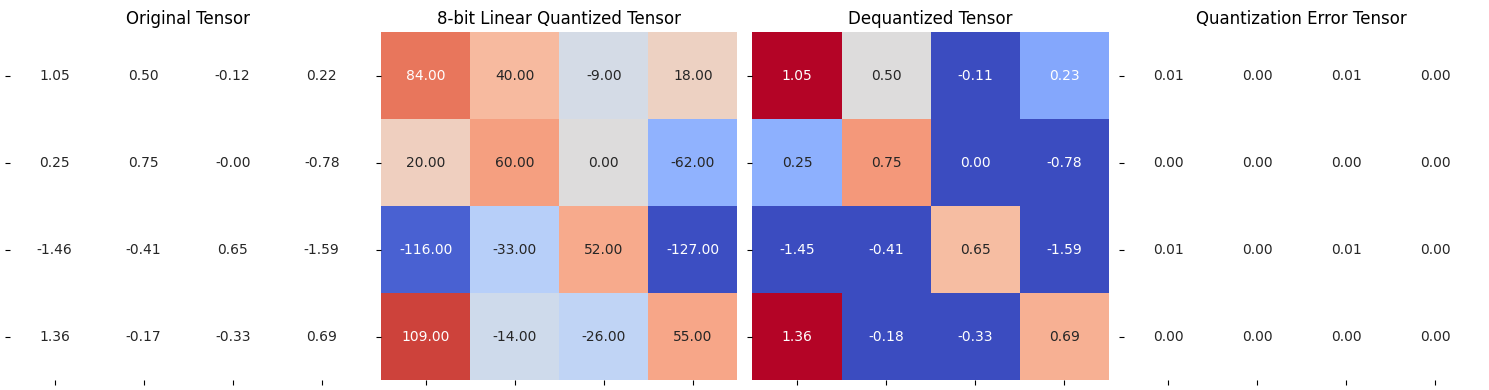

In [10]:
plot_quantization_errors(
    test_tensor, quantized_tensor, dequantized_tensor)

- We see the original tensor is similar to de quantized tensor.

- QUantization Error Tensor is also low.


In [15]:
print(f"""Quantization Error : \
{quantization_error(test_tensor, dequantized_tensor)}""")

Quantization Error : 1.4086173905525357e-05


Trade off:
- Utiization of qunatized Range:
  - When using asymmetric quantization, the quantized range is fully utilized.
  - When symmetric mode, if the float range is biased towards one side, this will result in a quantized range where a part of the range is dedicated to values that we'll never see.
  (RELU where the output is positive.)

- Simplicity: Symmetric mode is much simpler compared to asymmetric mode.

- Memory: We dont store the zero-point for symmetric qunatization.

- Asymmetric qunatization is used when we qunatise to 2,3 or 4 bits

- Symmetric qunatization is used when we quantize to 8 bits.